<!-- Título principal -->
<p align="center" style="font-size:40px; font-weight:bold;">
  Project 2: Signal-based environment detection
</p>
<p align="center" style="font-size:30px;">
Computational Learning and Deep Learning
</p>
<!-- Subtítulo de la escuela -->
<p align="center" style="font-size:30px;">
  Barcelona School of Economics
</p>

<!-- Nombre del curso -->
<p align="center" style="font-size:25px;">
  Data Science for Decision Making
</p>

<!-- Lista de miembros -->
<p align="center" style="font-size:20px;">
  <b></b>
</p>

<p align="center" style="font-size:18px;">
  Maria Simakova
  
</p>

# Initial settings

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import f_oneway, kurtosis, skew
import re
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb


In [58]:
#Load all the available datasets
X_train=pd.read_csv("/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /in class/cmldl-bse-n-nchallenge/XTRAIN.csv")
X_test=pd.read_csv("/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /in class/cmldl-bse-n-nchallenge/XTEST.csv")
y_train=pd.read_csv("/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /in class/cmldl-bse-n-nchallenge/yTRAIN.csv")

In [59]:
X_train.head()

,Unnamed: 0,order_id,id_seq,time,Xo,Yo,Zo,Wo,Xv,Yv,Zv,Xa,Ya,Za,signal_strength
0,76289,596_0,12,0,-0.24880,-0.95670,-0.14811,-0.029805,0.008689,-0.096178,0.23727,-2.29300,3.4044,-11.8540,91.392636
1,76290,596_1,12,1,-0.24890,-0.95665,-0.14828,-0.029762,-0.040826,0.010690,0.14966,-2.11220,3.9464,-11.0480,93.788417
2,76291,596_2,12,2,-0.24915,-0.95656,-0.14843,-0.029624,-0.087364,0.102670,0.23007,0.28025,4.5004,-10.4220,73.283695
3,76292,596_3,12,3,-0.24940,-0.95648,-0.14858,-0.029657,-0.127250,-0.026757,0.20735,-1.12950,6.1046,-9.0398,92.094719
4,76293,596_4,12,4,-0.24971,-0.95638,-0.14866,-0.029698,-0.069432,-0.055997,0.25691,5.80450,6.3839,-10.4890,95.143892


In [60]:
X_test.head()

,Unnamed: 0,order_id,id_seq,time,Xo,Yo,Zo,Wo,Xv,Yv,Zv,Xa,Ya,Za,signal_strength
0,1,0_0,8099,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,70.520673
1,2,0_1,8099,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128,86.709722
2,3,0_2,8099,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,96.543145
3,4,0_3,8099,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,82.640042
4,5,0_4,8099,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,98.348271


In [61]:
y_train.head()

,Unnamed: 0,id_seq,group_id,condition
0,597,12,8,B2
1,598,13,4,B1
2,599,17,16,B3
3,600,21,20,A2
4,601,23,13,A1


In [62]:
print(X_train.columns)
print(y_train.columns)

Index(['Unnamed: 0', 'order_id', 'id_seq', 'time', 'Xo', 'Yo', 'Zo', 'Wo',
       'Xv', 'Yv', 'Zv', 'Xa', 'Ya', 'Za', 'signal_strength'],
      dtype='object')
Index(['Unnamed: 0', 'id_seq', 'group_id', 'condition'], dtype='object')


# First exploratory data analysis (EDA)

#### Sensor exploration

We are asked to predict the target `condition`from the y_train dataset, using the following measurements: 
- angular velocities (`Xa`, `Ya`, `Za`)
- velocities (`Xv`, `Yv`, `Zv`)
- orientations (`Xo`, `Yo`, `Zo`, `Wo`)
- `signal strength`
- `time` variable indicating the timestep.
- `group_id` (experimental run identifier) which is only present in the `yTRAIN` dataset
- `id_seq` serves as identifiers for both the training and test datasets (`XTRAIN`, `XTEST`, and `yTRAIN`).


In [ ]:
def plot_separate_sensor_groups(df, groupby_column='id_seq', time_column='time'):
    """
    Plot separate time series for each sensor prefix group (X, Y, Z, W), 
    with individual sensor lines in each plot.
    """
    # Filter to numeric columns and exclude time/group columns
    sensor_columns = df.select_dtypes(include=[np.number]).columns
    sensor_columns = [col for col in sensor_columns if col not in [time_column, groupby_column]]
    
    # Group sensor columns by first letter
    sensor_groups = {
    'Orientation': ['Xo', 'Yo', 'Zo', 'Wo'],
    'Velocity': ['Xv', 'Yv', 'Zv'],
    'Angular Velocity': ['Xa', 'Ya', 'Za']}
    for col in sensor_columns:
        prefix = col[0]
        if prefix in sensor_groups:
            sensor_groups[prefix].append(col)
    
    for prefix, columns in sensor_groups.items():
        if not columns:
            continue  # Skip if no columns for this prefix

        grouped_df = df.groupby([groupby_column, time_column])[columns].mean().reset_index()
        
        plt.figure(figsize=(10, 4))
        for col in columns:
            col_data = grouped_df.groupby(time_column)[col]
            mean = col_data.mean()
            ci = col_data.sem() * 1.96  # 95% CI

            plt.plot(mean.index, mean.values, label=col, linewidth=2)
            plt.fill_between(mean.index, mean - ci, mean + ci, alpha=0.2)
        
        plt.title(f"{prefix}-Group Sensor Readings Over Time")
        plt.xlabel(time_column)
        plt.ylabel("Average Sensor Value")
        plt.legend(title=f"{prefix} Sensors")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


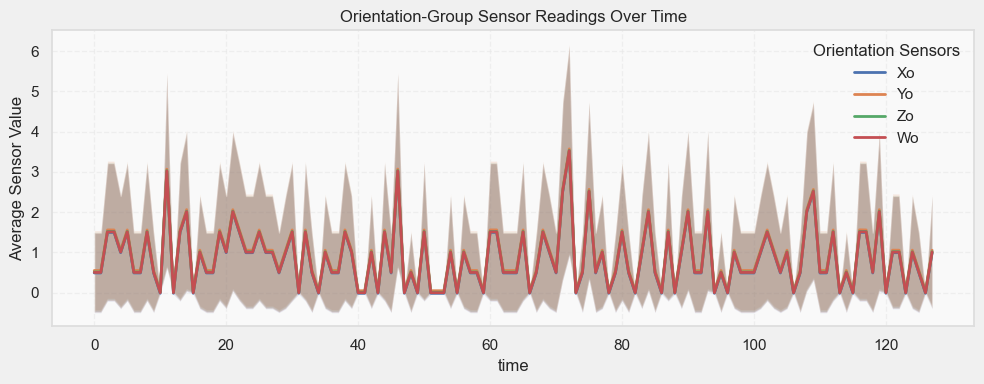

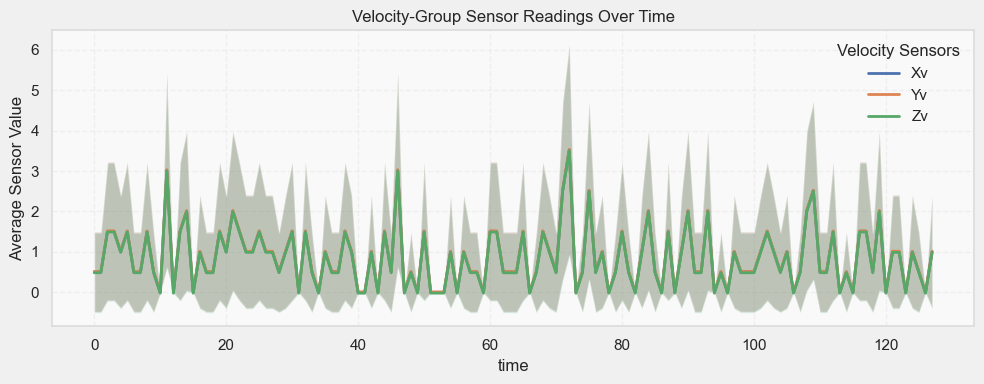

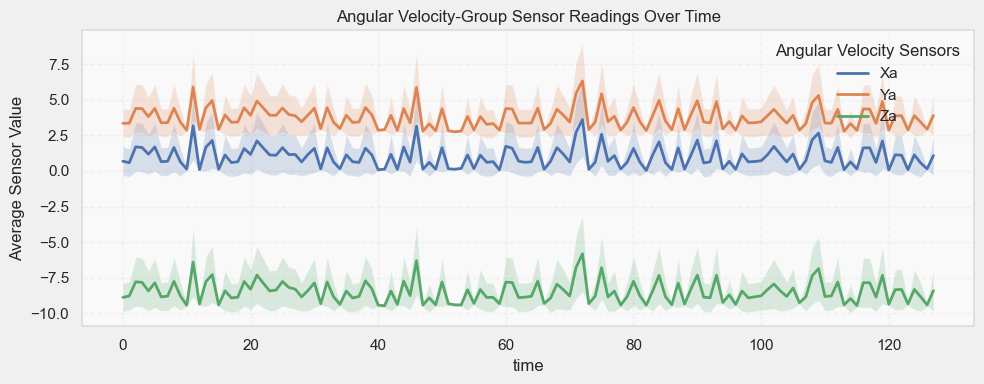

In [64]:
plot_separate_sensor_groups(X_train, groupby_column='id_seq', time_column='time')



The distribution of the sensor's behaviour over time shows, that: 
- The **orientation sensors** (Xo, Yo, Zo, Wo) change a lot, meaning the device is probably rotating or moving in different directions often. 
- The **velocity sensors** (Xv, Yv, Zv) show quick bursts of movement, like something starting and stopping—maybe walking or shaking. 
- The **angular velocity sensors** (Xa, Ya, Za) give us info about how fast the device is spinning, and here we can see strong patterns, especially in Za, which goes negative a lot. This tells us there's a lot of spinning or turning happening in that direction. 

Xo: p = 0.00000
Yo: p = 0.03235
Zo: p = 0.58272
Wo: p = 0.42814
Xv: p = 0.65732
Yv: p = 0.66631
Zv: p = 0.51991
Xa: p = 0.58629
Ya: p = 0.78505
Za: p = 0.71850


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/1466550844.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




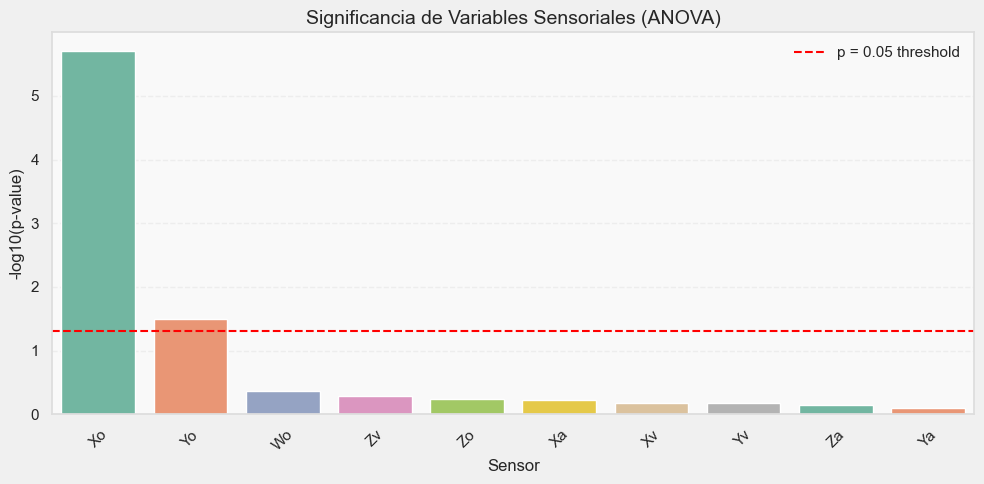

In [ ]:
merged_df = X_train.merge(y_train, on="id_seq", how="left")
# Example using sensor columns
sensor_columns = ['Xo', 'Yo', 'Zo', 'Wo', 'Xv', 'Yv', 'Zv', 'Xa', 'Ya', 'Za']
p_values = {}

for col in sensor_columns:
    grouped = [merged_df[merged_df['condition'] == cond][col] for cond in merged_df['condition'].unique()]
    f_stat, p_val = f_oneway(*grouped)
    p_values[col] = p_val
    print(f"{col}: p = {p_val:.5f}")
pval_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])
pval_df['-log10(p)'] = -np.log10(pval_df['p_value'])
pval_df = pval_df.sort_values(by='-log10(p)', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=pval_df.reset_index(), x='index', y='-log10(p)', palette='Set2')
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05 threshold')
plt.title("Significancia de Variables Sensoriales (ANOVA)", fontsize=14)
plt.xlabel("Sensor")
plt.ylabel("-log10(p-value)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


The only significantly affected sensors by the condition type are `Xo` and `Yo` (at 5% significance level).

Therefore, based on this statistical test could be concluded that they might be the most essential for prediction. All other sensors do not show meaningful variation across conditions, so they may be less useful (unless they interact in some way or capture time-dependent patterns).

#### Experimental Run: "group_id"

The variable `group_id`denotes the number of a specific experimental run. By analyzing this variable we can obtain interesting insights regarding the specific characteristics used and the final 'condition' obtained in each case. 

First we ensure that each experimental run only allows for one possible condition outcome: 

In [66]:
y_train.groupby('group_id').condition.nunique().max()

1

In [67]:
y_train['group_id'].nunique()

72

Perfect, each group id condition remains constant across all the available time steps. And there are 72 in total.

#### Target variable: "Condition" distribution

There are 9 possible outcomes which further will be encoded to values between 0-8, in the previous section those were already aggregated to those values, for some specific visualizations and saved in the merged_df dataframe. 

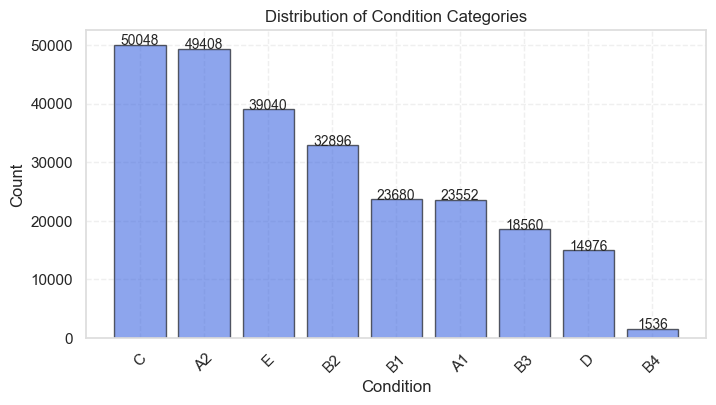

In [ ]:
# Count occurrences of each condition
condition_counts = merged_df['condition'].value_counts()

# Create figure with a white background
plt.figure(figsize=(8, 4), facecolor='none')  # Set figure background to white
ax = plt.gca()  # Get the current axis
ax.set_facecolor('none')  # Ensure the plot background is also white

# Create a vertical bar chart
plt.bar(condition_counts.index, condition_counts.values, color='royalblue', alpha=0.6, edgecolor='black')

# Add labels and title
plt.xlabel("Condition")
plt.ylabel("Count")
plt.title("Distribution of Condition Categories")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show values on top of bars
for index, value in enumerate(condition_counts.values):
    plt.text(index, value + 2, str(value), ha='center', fontsize=10)

# Show plot
plt.show()



`Condition` at first glance appears to be highly imbalanced, this could introduce bias in further models, specifically in such as logistic regression, decision trees and random forests, as those tend to **minimize overall error without considering class distribution**. 

In [69]:
# Are analyzing the first sequence of 128 steps of the data set more closely
sequence = X_train.head(128)

In [70]:
sequence.describe()

,Unnamed: 0,id_seq,time,Xo,Yo,Zo,Wo,Xv,Yv,Zv,Xa,Ya,Za,signal_strength
count,128.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,76352.500000,12.0,63.500000,-0.267135,-0.951683,-0.147599,-0.032308,-0.008126,-0.067291,0.211889,0.314864,3.114043,-9.376960,91.238664
std,37.094474,0.0,37.094474,0.009970,0.002824,0.000429,0.001669,0.108611,0.093430,0.062510,1.989310,2.627604,2.987686,4.491756
min,76289.000000,12.0,0.000000,-0.282330,-0.956700,-0.148660,-0.035469,-0.301240,-0.277980,0.055586,-5.141400,-2.849300,-15.919000,73.283695
25%,76320.750000,12.0,31.750000,-0.275728,-0.954192,-0.147858,-0.033664,-0.075705,-0.132633,0.163123,-1.028200,1.391125,-11.078000,89.519493
50%,76352.500000,12.0,63.500000,-0.267970,-0.951465,-0.147555,-0.032269,-0.011652,-0.076032,0.209465,0.153830,3.294100,-9.456600,92.091425
75%,76384.250000,12.0,95.250000,-0.258610,-0.949240,-0.147257,-0.031131,0.059075,-0.001250,0.254275,1.456675,4.800175,-7.086925,94.174677
max,76416.000000,12.0,127.000000,-0.248800,-0.947210,-0.146910,-0.029624,0.244150,0.167490,0.351880,5.804500,9.081000,-2.574200,98.455666


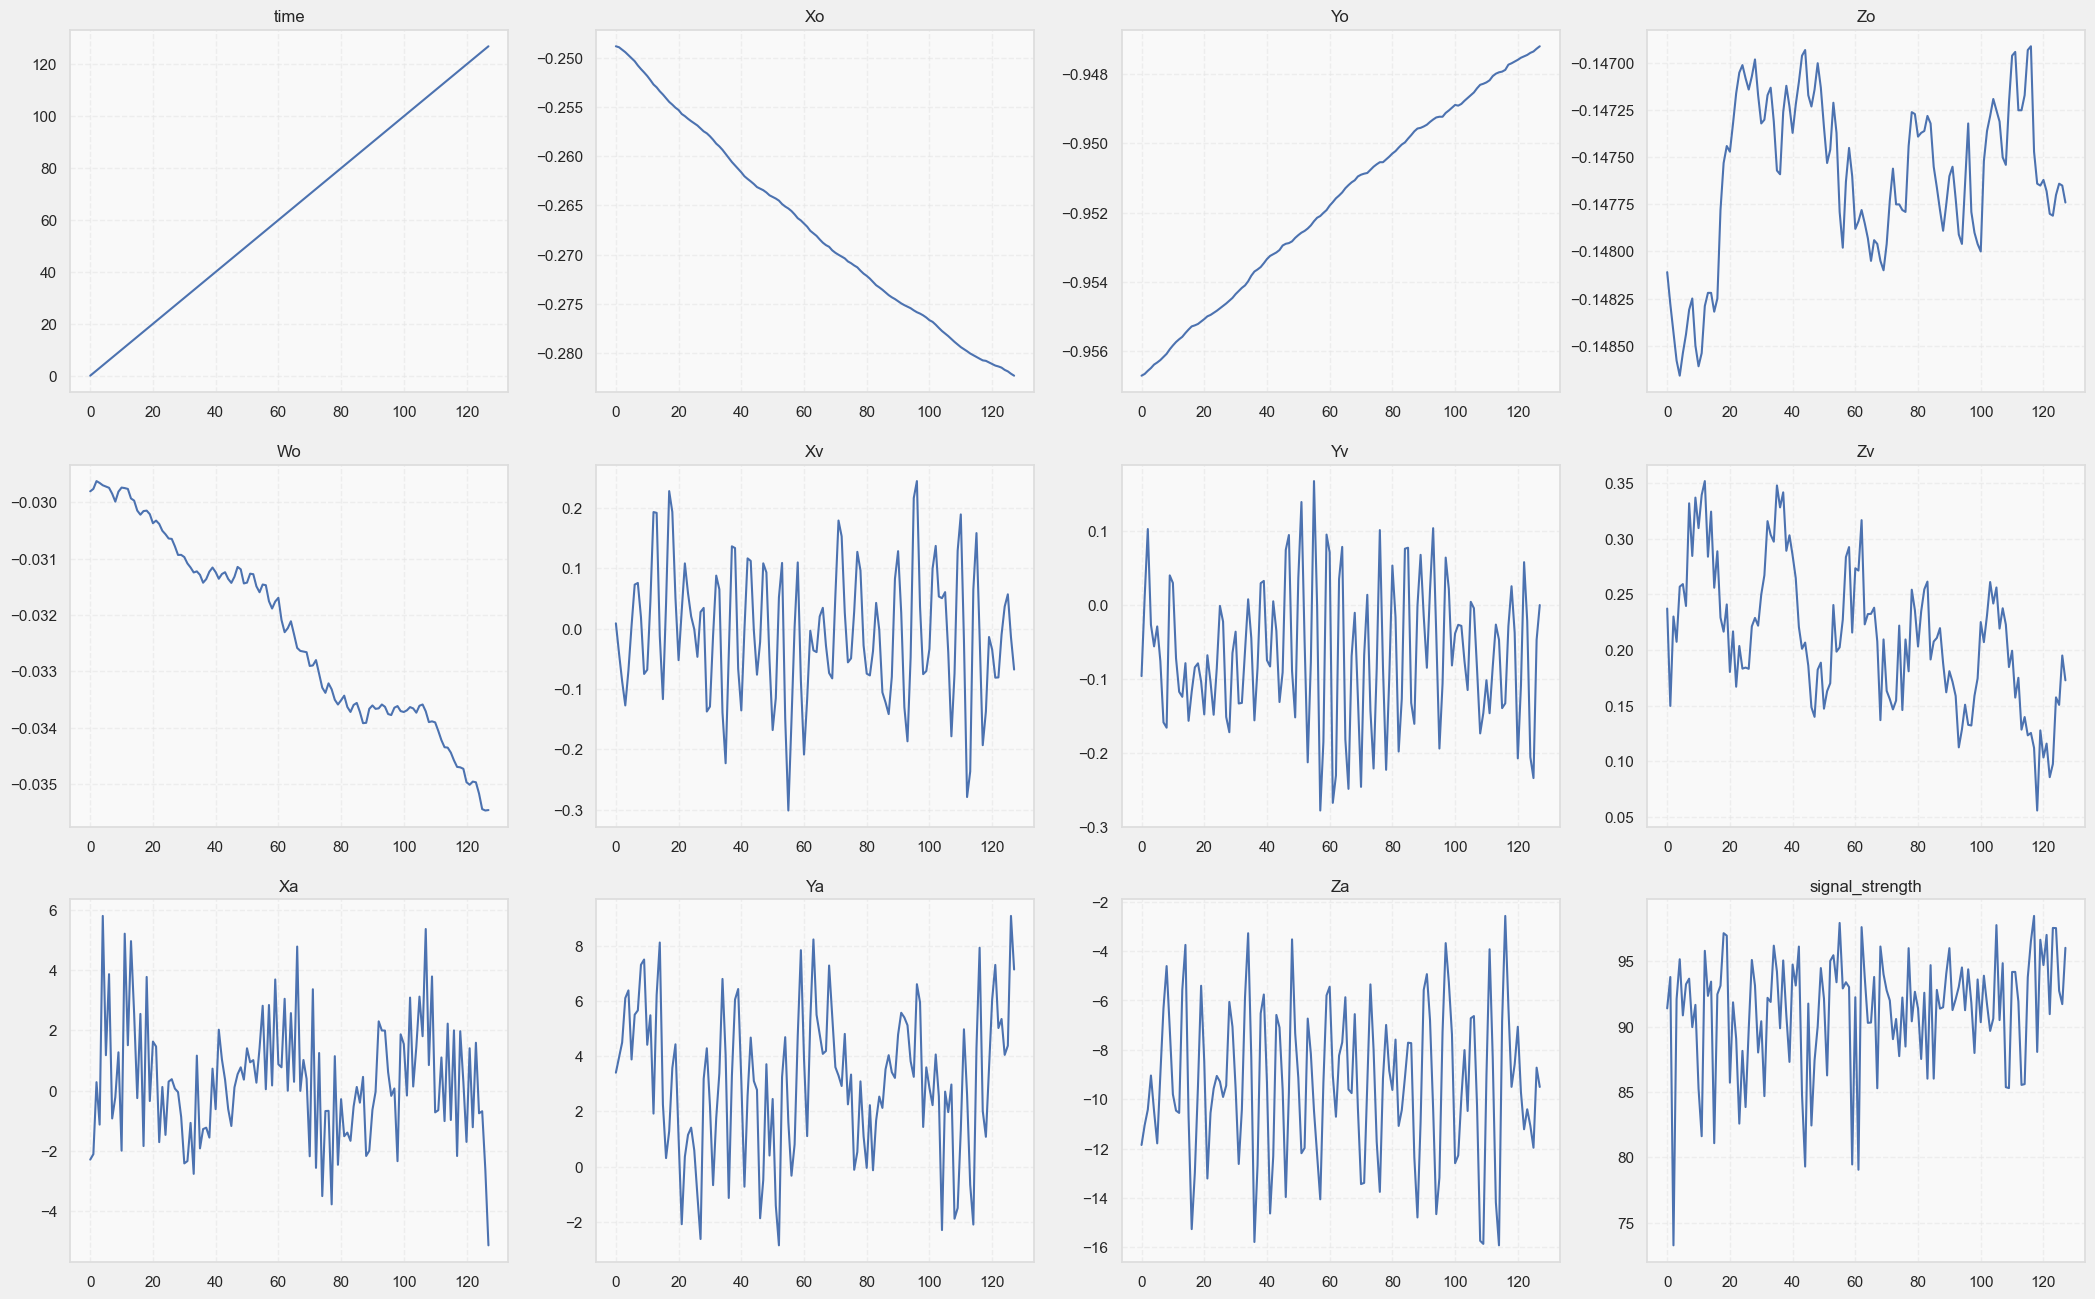

In [71]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(sequence.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(sequence[col])
    plt.title(col)

This sequence shows a mix of stable and dynamic sensor behavior:
- Orientation sensors **(Xo, Yo, Wo)** change smoothly, indicating gradual motion.
- Velocity and angular velocity sensors (Xv, Yv, Xa, Za) fluctuate rapidly, suggesting active movement. 
- **Za** shows strong negative spikes, pointing to sharp angular changes. 
- **Signal_strength** is mostly stable with minor drops.

# Feature engineering

The prepare_data function we will take the data and transform it into frequency-based features using the **Fast Fourier Transform (FFT)**. 
For each sequence of sensors (identified by id_seq), it collects the velocity `(Xv, Yv, Zv)` and acceleration `(Xa, Ya, Za)` signals and sorts them by time. 

Then, it applies FFT to each signal to convert it from the time domain to the frequency domain. 

In [72]:
import math

def prepare_data(t):
    def f(d):
        d=d.sort_values(by=['time'])
        return pd.DataFrame({
         'vx':[ d['Xv'].values ],
         'vy':[ d['Yv'].values ],
         'vz':[ d['Zv'].values ],
         'ax':[ d['Xa'].values ],
         'ay':[ d['Ya'].values ],
         'az':[ d['Za'].values ],
        })

    t= t.groupby('id_seq').apply(f)

    def mfft(x):
        return [ x/math.sqrt(128.0) for x in np.absolute(np.fft.fft(x)) ][1:65]

    t['vx_f']=[ mfft(x) for x in t['vx'].values ]
    t['vy_f']=[ mfft(x) for x in t['vy'].values ]
    t['vz_f']=[ mfft(x) for x in t['vz'].values ]
    t['ax_f']=[ mfft(x) for x in t['ax'].values ]
    t['ay_f']=[ mfft(x) for x in t['ay'].values ]
    t['az_f']=[ mfft(x) for x in t['az'].values ]
    return t

In [73]:
t=prepare_data(X_train)
# Merge the processed data with condition of y_train
t=pd.merge(t,y_train[['id_seq','condition','group_id']],on='id_seq')
t=t.rename(columns={"condition": "y"})

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/1835556945.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [74]:
classes = (y_train['condition'].value_counts()).index
aux = X_train.merge(y_train, on='id_seq', how='inner')

Next, the data can be converted to **euler angles**, which makes for example the orientation data easier to understand.

Converting `(x, y, z, w)` into three angles:

**X** → Roll (rotation around the x-axis): Tilting side to side. 

**Y** → Pitch (rotation around the y-axis): Tilting forward or backward, like nodding your head.

**Z** → Yaw (rotation around the z-axis): Turning left or right.

In [75]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [76]:
# Ensure each one has the same magnitude (lenght equal to 1)
def normalize_quaternion (df):
    df['norm_quat'] = (df['Xo']**2 + df['Yo']**2 + df['Zo']**2 + df['Wo']**2)
    df['mod_quat'] = (df['norm_quat'])**0.5
    df['norm_X'] = df['Xo'] / df['mod_quat']
    df['norm_Y'] = df['Yo'] / df['mod_quat']
    df['norm_Z'] = df['Zo'] / df['mod_quat']
    df['norm_W'] = df['Wo'] / df['mod_quat']
    return df

In [77]:
data = normalize_quaternion(X_train)
test = normalize_quaternion(X_test)

Converting normalized quaternions in the DataFrame to Euler angles (roll, pitch, yaw):

In [78]:
def quaternion_to_euler_angles (df):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = df['norm_X'].tolist(), df['norm_Y'].tolist(), df['norm_Z'].tolist(), df['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    df['euler_x'] = nx
    df['euler_y'] = ny
    df['euler_z'] = nz
    return df

In [79]:
X_train = quaternion_to_euler_angles(X_train)
X_test = quaternion_to_euler_angles(X_test)

In [80]:
def feat_eng(X_train):
    
    df = pd.DataFrame()
    X_train['totl_anglr_vel'] = (X_train['Xa']**2 + X_train['Ya']**2 + X_train['Za']**2)** 0.5
    X_train['totl_linr_acc'] = (X_train['Xv']**2 + X_train['Yv']**2 + X_train['Zv']**2)**0.5
    X_train['totl_xyz'] = (X_train['Xo']**2 + X_train['Yo']**2 + X_train['Zo']**2)**0.5
    X_train['acc_vs_vel'] = X_train['totl_linr_acc'] / X_train['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in X_train.columns:
        if col in ['order_id','id_seq','time']:
            continue
        df[col + '_mean'] = X_train.groupby(['id_seq'])[col].mean()
        df[col + '_median'] = X_train.groupby(['id_seq'])[col].median()
        df[col + '_max'] = X_train.groupby(['id_seq'])[col].max()
        df[col + '_min'] = X_train.groupby(['id_seq'])[col].min()
        df[col + '_std'] = X_train.groupby(['id_seq'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = X_train.groupby(['id_seq'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = X_train.groupby('id_seq')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = X_train.groupby(['id_seq'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = X_train.groupby(['id_seq'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

The above part computes the **statistical summaries** (mean, median, max, min, standard deviation, range, etc.) for each sequence (id_seq). 

Additionally creating derived features like angular velocity, total acceleration, and the ratio between them. 

In [81]:
# Applying the function
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)
print ("New features: ",X_train.shape)

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/3286324957.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/3286324957.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/3286324957.py:21: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

New features:  (1982, 300)


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/3286324957.py:25: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_8200/3286324957.py:26: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



For further statistical properties, other specific features are calculated such as: 

- **kurtosis** the sharpness of the data distribution
- **CPT5**: Calculates a specific statistical measure based on the data's exponential values and standard deviation.
- **skewness** the asymmetry of the data
- **SSC**: Calculates the Slope Sign Change (SSC), capturing the number of times the data's slope changes.
- **wave length** the total change in the data
- **norm_entropy**: Calculates the normalized entropy of the data by raising the absolute values to a power.
- **SRAV**: Computes the Squared Root of Average (SRA), a measure of the data's average behavior.
- **mean absolute value**
- **zero-crossings** the number of times the data changes sign 

These features are important in sensor data analysis because they help detect patterns, anomalies or trends. 

In [ ]:
def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))

In [ ]:
# Compute the previously defined new features for the dataset
def fe_advanced_stats(X_train):
    
    df = pd.DataFrame()
    
    for col in X_train.columns:
        if col in ['order_id','id_seq','time']:
            continue
        if re.search(r'^[XYZW]o_', col):
            continue
            
        print ("FE on column ", col, "...")
        
        df[col + '_skew'] = X_train.groupby(['id_seq'])[col].skew()
        df[col + '_mad'] = X_train.groupby(['id_seq'])[col].mad()
        df[col + '_q25'] = X_train.groupby(['id_seq'])[col].quantile(0.25)
        df[col + '_q75'] = X_train.groupby(['id_seq'])[col].quantile(0.75)
        df[col + '_q95'] = X_train.groupby(['id_seq'])[col].quantile(0.95)
        df[col + '_iqr'] = df[col + '_q75'] - df[col + '_q25']
        df[col + '_CPT5'] = X_train.groupby(['id_seq'])[col].apply(CPT5) 
        df[col + '_SSC'] = X_train.groupby(['id_seq'])[col].apply(SSC) 
        df[col + '_skewness'] = X_train.groupby(['id_seq'])[col].apply(skewness)
        df[col + '_wave_lenght'] = X_train.groupby(['id_seq'])[col].apply(wave_length)
        df[col + '_norm_entropy'] = X_train.groupby(['id_seq'])[col].apply(norm_entropy)
        df[col + '_SRAV'] = X_train.groupby(['id_seq'])[col].apply(SRAV)
        df[col + '_kurtosis'] = X_train.groupby(['id_seq'])[col].apply(_kurtosis) 
        df[col + '_zero_crossing'] = X_train.groupby(['id_seq'])[col].apply(zero_crossing) 
        
    return df

In [84]:
basic_fe = ['linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z',
           'angular_velocity_X','angular_velocity_Y','angular_velocity_Z']

In [85]:
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)
X_train.replace(-np.inf,0,inplace=True)
X_train.replace(np.inf,0,inplace=True)
X_test.replace(-np.inf,0,inplace=True)
X_test.replace(np.inf,0,inplace=True)

Tranform `condition`to numerical values between 0-8

In [86]:
y_train['condition'] = LabelEncoder().fit_transform(y_train['condition'])

# Models 

### Random Forest
Begining with a simpler tree based model to predict the condition variabel. It splits the data into 10 folds, trains the model on each fold, and evaluates its performance on the validation set. For each fold, it calculates the predicted probabilities for X_test and averages them across all folds. 

In [ ]:
# Initialize Stratified K-Fold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

# Initialize arrays for storing predictions and scores
predicted = np.zeros((X_test.shape[0], 9))  # Assuming 9 classes
measured = np.zeros((X_train.shape[0]))
score = 0
best_score = 0
best_predicted = None  # Store the best prediction probabilities

# Perform cross-validation
for times, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train['condition'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    
    model.fit(X_train.iloc[trn_idx], y_train['condition'][trn_idx])
    
    measured[val_idx] = model.predict(X_train.iloc[val_idx])
    fold_predicted = model.predict_proba(X_test) / folds.n_splits
    predicted += fold_predicted  # Average predictions over folds
    fold_score = model.score(X_train.iloc[val_idx], y_train['condition'][val_idx])
    score += fold_score
    
    print("Fold: {} score: {}".format(times, fold_score))

    # Save the best predictions if this fold has the highest score
    if fold_score > best_score:
        best_score = fold_score
        best_predicted = fold_predicted.copy()  # Store the best fold predictions
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns

Fold: 0 score: 0.9045226130653267
Fold: 1 score: 0.8894472361809045
Fold: 2 score: 0.898989898989899
Fold: 3 score: 0.8282828282828283
Fold: 4 score: 0.8636363636363636
Fold: 5 score: 0.8585858585858586
Fold: 6 score: 0.8787878787878788
Fold: 7 score: 0.9141414141414141
Fold: 8 score: 0.8888888888888888
Fold: 9 score: 0.9242424242424242


In [88]:
# Convert best_predicted (4D vectors) into class labels (1D array)
y_test_pred_best = np.argmax(best_predicted, axis=-1)

# Ensure X_test contains id_seq
X_test = X_test.reset_index()  # Bring back id_seq as a column

# Create Kaggle submission DataFrame
submission = pd.DataFrame({'id_seq': X_test['id_seq'], 'condition': y_test_pred_best})

# Save to CSV for Kaggle submission
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'.")

# Accuracy of 0.87 in kaggle
# (Most of the kaggle sumbissions were tested on the first in class kaggle link, since they give the same result as the final one)

Submission file saved as 'submission.csv'.


In [89]:
print('Avg Accuracy RF', score / folds.n_splits)

Avg Accuracy RF 0.8849525404801787


#### Artificial Neural Network (ANN)

In [ ]:
# Extract `id_seq` first to avoid issues later
id_seq_test = X_test['id_seq'].copy()

# Drop non-numeric columns before scaling
non_numeric_cols = ['id_seq', 'index', 'level_0']
X_train_numeric = X_train.drop(columns=[col for col in non_numeric_cols if col in X_train.columns], errors='ignore')
X_test_numeric = X_test.drop(columns=[col for col in non_numeric_cols if col in X_test.columns], errors='ignore')

# Scale only numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Define Neural Network model
def build_model(input_dim, output_dim):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),  # Input layer
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_dim, activation='softmax')  # Output layer (softmax for classification)
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform K-Fold Cross Validation
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)
predicted = np.zeros((X_test_scaled.shape[0], 9))  # Assuming 9 classes
measured = np.zeros((X_train_scaled.shape[0]))
score = 0
best_score = 0
best_predicted = None

for times, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled, y_train['condition'].values)):
    model = build_model(X_train_scaled.shape[1], 9)
    
    # Train the model
    model.fit(X_train_scaled[trn_idx], y_train['condition'][trn_idx], 
              validation_data=(X_train_scaled[val_idx], y_train['condition'][val_idx]),
              epochs=50, batch_size=32, verbose=1)
    
    # Predict on validation and test sets
    measured[val_idx] = np.argmax(model.predict(X_train_scaled[val_idx]), axis=-1)
    fold_predicted = model.predict(X_test_scaled) / folds.n_splits
    predicted += fold_predicted  # Average predictions over folds
    
    # Evaluate fold performance
    fold_score = model.evaluate(X_train_scaled[val_idx], y_train['condition'][val_idx], verbose=0)[1]
    score += fold_score
    
    print(f"Fold {times}: Accuracy = {fold_score:.4f}")

    if fold_score > best_score:
        best_score = fold_score
        best_predicted = fold_predicted.copy()

# Accuracy of 0.67 in kaggle


Epoch 1/50


/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2655 - loss: 2.1917 - val_accuracy: 0.4472 - val_loss: 1.8409
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - loss: 1.2950 - val_accuracy: 0.6080 - val_loss: 1.4538
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 1.0877 - val_accuracy: 0.6683 - val_loss: 1.1641
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7014 - loss: 0.9247 - val_accuracy: 0.6834 - val_loss: 1.0300
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7340 - loss: 0.7966 - val_accuracy: 0.6985 - val_loss: 0.9787
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7648 - loss: 0.7221 - val_accuracy: 0.7085 - val_loss: 0.9204
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7835 - loss: 0.6733 - val_accuracy: 0.6935 - val_loss: 0.9103
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8069 - loss: 0.6288 - val_accuracy: 0.6633 - val_loss: 0.8791
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2731 - loss: 2.1605 - val_accuracy: 0.3769 - val_loss: 1.7447
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5413 - loss: 1.3701 - val_accuracy: 0.6181 - val_loss: 1.4103
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 1.0829 - val_accuracy: 0.6633 - val_loss: 1.2278
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7101 - loss: 0.9336 - val_accuracy: 0.7337 - val_loss: 1.0635
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7396 - loss: 0.8387 - val_accuracy: 0.7387 - val_loss: 1.0024
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7860 - loss: 0.7439 - val_accuracy: 0.7337 - val_loss: 0.9195
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7909 - loss: 0.6492 - val_accuracy: 0.7337 - val_loss: 1.0043
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8142 - loss: 0.6257 - val_accuracy: 0.7739 - val_loss: 0.8600
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2883 - loss: 2.1398 - val_accuracy: 0.4444 - val_loss: 1.7699
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5278 - loss: 1.4311 - val_accuracy: 0.5505 - val_loss: 1.4278
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 1.0809 - val_accuracy: 0.6717 - val_loss: 1.1551
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6834 - loss: 1.0105 - val_accuracy: 0.7374 - val_loss: 0.9413
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7452 - loss: 0.8320 - val_accuracy: 0.7626 - val_loss: 0.8589
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7770 - loss: 0.7266 - val_accuracy: 0.7475 - val_loss: 0.8145
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7849 - loss: 0.6823 - val_accuracy: 0.7222 - val_loss: 0.8129
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7862 - loss: 0.6413 - val_accuracy: 0.7879 - val_loss: 0.7264
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2554 - loss: 2.2589 - val_accuracy: 0.3939 - val_loss: 1.9599
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5708 - loss: 1.3450 - val_accuracy: 0.4798 - val_loss: 1.6187
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 1.0705 - val_accuracy: 0.6010 - val_loss: 1.3364
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6682 - loss: 0.9823 - val_accuracy: 0.6667 - val_loss: 1.2248
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7300 - loss: 0.8394 - val_accuracy: 0.6414 - val_loss: 1.1400
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7542 - loss: 0.7760 - val_accuracy: 0.6768 - val_loss: 1.0923
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7908 - loss: 0.6783 - val_accuracy: 0.6566 - val_loss: 1.0994
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.6398 - val_accuracy: 0.6970 - val_loss: 1.0114
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2737 - loss: 2.2300 - val_accuracy: 0.5051 - val_loss: 1.7923
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5809 - loss: 1.2907 - val_accuracy: 0.5859 - val_loss: 1.4549
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6999 - loss: 0.9673 - val_accuracy: 0.6010 - val_loss: 1.1807
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7573 - loss: 0.8350 - val_accuracy: 0.6364 - val_loss: 1.0655
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7687 - loss: 0.7245 - val_accuracy: 0.6970 - val_loss: 0.9315
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.6807 - val_accuracy: 0.6970 - val_loss: 0.9000
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7989 - loss: 0.6244 - val_accuracy: 0.7222 - val_loss: 0.8753
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8018 - loss: 0.6026 - val_accuracy: 0.7424 - val_loss: 0.8599
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2855 - loss: 2.1225 - val_accuracy: 0.4747 - val_loss: 1.8374
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5879 - loss: 1.3141 - val_accuracy: 0.4899 - val_loss: 1.4640
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 1.1037 - val_accuracy: 0.5808 - val_loss: 1.2183
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7152 - loss: 0.9084 - val_accuracy: 0.6212 - val_loss: 1.1402
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7551 - loss: 0.8029 - val_accuracy: 0.6667 - val_loss: 1.0122
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7803 - loss: 0.7358 - val_accuracy: 0.6970 - val_loss: 0.9871
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7994 - loss: 0.6479 - val_accuracy: 0.6970 - val_loss: 0.9780
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8032 - loss: 0.6533 - val_accuracy: 0.7273 - val_loss: 0.8825
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2447 - loss: 2.3017 - val_accuracy: 0.4596 - val_loss: 1.8357
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5531 - loss: 1.3569 - val_accuracy: 0.5909 - val_loss: 1.4382
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6493 - loss: 1.0659 - val_accuracy: 0.6364 - val_loss: 1.2361
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7022 - loss: 0.9322 - val_accuracy: 0.6616 - val_loss: 1.1146
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7406 - loss: 0.7950 - val_accuracy: 0.6465 - val_loss: 1.0264
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.6934 - val_accuracy: 0.6768 - val_loss: 0.9791
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7771 - loss: 0.6815 - val_accuracy: 0.7121 - val_loss: 0.9787
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7993 - loss: 0.6166 - val_accuracy: 0.7172 - val_loss: 0.9248
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2384 - loss: 2.2298 - val_accuracy: 0.4697 - val_loss: 1.6926
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5826 - loss: 1.3056 - val_accuracy: 0.6162 - val_loss: 1.3606
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6608 - loss: 1.0723 - val_accuracy: 0.6717 - val_loss: 1.1109
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6885 - loss: 0.9682 - val_accuracy: 0.7020 - val_loss: 0.9626
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7323 - loss: 0.8332 - val_accuracy: 0.7626 - val_loss: 0.8543
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7617 - loss: 0.7709 - val_accuracy: 0.7424 - val_loss: 0.7793
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8107 - loss: 0.6265 - val_accuracy: 0.7828 - val_loss: 0.7100
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8256 - loss: 0.6280 - val_accuracy: 0.7879 - val_loss: 0.7032
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2736 - loss: 2.1490 - val_accuracy: 0.4343 - val_loss: 1.7717
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5382 - loss: 1.3818 - val_accuracy: 0.6364 - val_loss: 1.4078
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6518 - loss: 1.1055 - val_accuracy: 0.7071 - val_loss: 1.1435
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7021 - loss: 0.9608 - val_accuracy: 0.7172 - val_loss: 1.0143
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7353 - loss: 0.8535 - val_accuracy: 0.7222 - val_loss: 0.8898
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7695 - loss: 0.7429 - val_accuracy: 0.7525 - val_loss: 0.8083
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7738 - loss: 0.7204 - val_accuracy: 0.7677 - val_loss: 0.7329
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8120 - loss: 0.6209 - val_accuracy: 0.8182 - val_loss: 0.7020
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2859 - loss: 2.1252 - val_accuracy: 0.4697 - val_loss: 1.9369
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5716 - loss: 1.3569 - val_accuracy: 0.5909 - val_loss: 1.4724
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6287 - loss: 1.1233 - val_accuracy: 0.6465 - val_loss: 1.3306
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6765 - loss: 0.9896 - val_accuracy: 0.6970 - val_loss: 1.0678
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7214 - loss: 0.8512 - val_accuracy: 0.7273 - val_loss: 1.0311
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519 - loss: 0.7769 - val_accuracy: 0.7576 - val_loss: 0.9307
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.6939 - val_accuracy: 0.7778 - val_loss: 0.8740
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - loss: 0.6510 - val_accuracy: 0.7677 - val_loss: 0.8162
Epo

The network is a feedforward neural network with three hidden layers (128, 64, and 32 neurons) using ReLU activation and BatchNormalization to stabilize training. The model uses softmax activation in the output layer for multi-class classification (9 classes). It is trained using Stratified K-Fold cross-validation. The predictions from each fold are averaged to get the final test set prediction. 

The main **drawback** of using this feedforward neural network (ANN) is that it does not capture temporal dependencies. Initially we had 128 time steps, but ANN treats each time step independently, it fails to account for the sequential nature of the data.

In [91]:
# Convert best_predicted probabilities to class labels
y_test_pred_best = np.argmax(best_predicted, axis=-1)

# Create submission DataFrame
submission = pd.DataFrame({'id_seq': id_seq_test, 'condition': y_test_pred_best})

# Save to CSV for Kaggle submission
submission.to_csv('submission_nn.csv', index=False)

print(f"Best Fold Score: {best_score:.4f} - Predictions saved to 'submission_nn.csv'.")


Best Fold Score: 0.8434 - Predictions saved to 'submission_nn.csv'.


#### Recurrent neural networks (RNN)
The following method instead accounts for time dependencies between the data, and it principle should be a more suitable approach:

In [92]:
# Reshape data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))  # Add time-step dimension
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define LSTM-based Recurrent Neural Network model
def build_model(input_shape, output_dim):
    model = keras.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),  # First LSTM layer
        keras.layers.LSTM(32, return_sequences=False),  # Second LSTM layer
        keras.layers.Dense(16, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_dim, activation='softmax')  # Output layer (softmax for classification)
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform K-Fold Cross Validation using LSTM
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)
predicted = np.zeros((X_test_scaled.shape[0], 9))  # Assuming 9 classes
measured = np.zeros((X_train_scaled.shape[0]))
score = 0
best_score = 0
best_predicted = None

for times, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled, y_train['condition'].values)):
    model = build_model((1, X_train_scaled.shape[1]), 9)  # Use LSTM input shape

    # Train the model
    model.fit(X_train_reshaped[trn_idx], y_train['condition'][trn_idx], 
              validation_data=(X_train_reshaped[val_idx], y_train['condition'][val_idx]),
              epochs=50, batch_size=32, verbose=1)
    
    # Predict on validation and test sets
    measured[val_idx] = np.argmax(model.predict(X_train_reshaped[val_idx]), axis=-1)
    fold_predicted = model.predict(X_test_reshaped) / folds.n_splits
    predicted += fold_predicted  # Average predictions over folds
    
    # Evaluate fold performance
    fold_score = model.evaluate(X_train_reshaped[val_idx], y_train['condition'][val_idx], verbose=0)[1]
    score += fold_score
    
    print(f"Fold {times}: Accuracy = {fold_score:.4f}")

    if fold_score > best_score:
        best_score = fold_score
        best_predicted = fold_predicted.copy()

# Convert best_predicted probabilities to class labels
y_test_pred_best = np.argmax(best_predicted, axis=-1)

# Create Kaggle submission DataFrame
submission = pd.DataFrame({'id_seq': id_seq_test, 'condition': y_test_pred_best})

# Save to CSV for Kaggle submission
submission.to_csv('submission_lstm.csv', index=False)

print(f"Best Fold Score: {best_score:.4f} - Predictions saved to 'submission_lstm.csv'.")

# Accuracy of 0.67 in kaggle


/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3569 - loss: 1.9540 - val_accuracy: 0.4975 - val_loss: 2.0756
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6257 - loss: 1.3165 - val_accuracy: 0.5126 - val_loss: 1.9763
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6957 - loss: 1.0754 - val_accuracy: 0.5729 - val_loss: 1.8490
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7531 - loss: 0.8975 - val_accuracy: 0.7035 - val_loss: 1.7076
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7711 - loss: 0.7788 - val_accuracy: 0.6784 - val_loss: 1.5234
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.6584 - val_accuracy: 0.7286 - val_loss: 1.3187
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8566 - loss: 0.5362 - val_accuracy: 0.7035 - val_loss: 1.1524
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8518 - loss: 0.5348 - val_accuracy: 0.7236 - val_loss:

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2694 - loss: 2.0304 - val_accuracy: 0.4523 - val_loss: 2.0963
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5346 - loss: 1.4713 - val_accuracy: 0.4874 - val_loss: 1.9756
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6820 - loss: 1.1387 - val_accuracy: 0.5427 - val_loss: 1.8449
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.9188 - val_accuracy: 0.5628 - val_loss: 1.6697
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.7459 - val_accuracy: 0.6985 - val_loss: 1.4526
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.6870 - val_accuracy: 0.7236 - val_loss: 1.2023
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8417 - loss: 0.5699 - val_accuracy: 0.7588 - val_loss: 1.0012
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.5228 - val_accuracy: 0.7638 - val_loss: 0.8521
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2763 - loss: 1.9639 - val_accuracy: 0.4798 - val_loss: 2.0784
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5487 - loss: 1.3796 - val_accuracy: 0.5000 - val_loss: 1.9571
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6686 - loss: 1.0856 - val_accuracy: 0.5505 - val_loss: 1.8370
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7297 - loss: 0.9366 - val_accuracy: 0.6162 - val_loss: 1.6517
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7542 - loss: 0.8155 - val_accuracy: 0.7172 - val_loss: 1.3981
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8161 - loss: 0.6706 - val_accuracy: 0.7677 - val_loss: 1.1889
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8367 - loss: 0.5656 - val_accuracy: 0.7929 - val_loss: 0.9539
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.4770 - val_accuracy: 0.7778 - val_loss: 0.8289
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2895 - loss: 2.0087 - val_accuracy: 0.3535 - val_loss: 2.0844
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5622 - loss: 1.4324 - val_accuracy: 0.4192 - val_loss: 1.9771
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6897 - loss: 1.1407 - val_accuracy: 0.5000 - val_loss: 1.8481
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7189 - loss: 0.9546 - val_accuracy: 0.5505 - val_loss: 1.7026
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7761 - loss: 0.8025 - val_accuracy: 0.6061 - val_loss: 1.5149
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.6731 - val_accuracy: 0.6364 - val_loss: 1.2773
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.5513 - val_accuracy: 0.6616 - val_loss: 1.0866
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8765 - loss: 0.4778 - val_accuracy: 0.7273 - val_loss: 0.9442
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3049 - loss: 1.9707 - val_accuracy: 0.4040 - val_loss: 2.0964
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5553 - loss: 1.4278 - val_accuracy: 0.5202 - val_loss: 1.9925
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6693 - loss: 1.1586 - val_accuracy: 0.5606 - val_loss: 1.8534
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7102 - loss: 0.9594 - val_accuracy: 0.6010 - val_loss: 1.6979
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.7891 - val_accuracy: 0.6515 - val_loss: 1.5099
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8090 - loss: 0.6671 - val_accuracy: 0.6667 - val_loss: 1.2829
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.5437 - val_accuracy: 0.7273 - val_loss: 1.0583
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.4840 - val_accuracy: 0.7374 - val_loss: 0.9072
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2408 - loss: 2.1005 - val_accuracy: 0.3333 - val_loss: 2.1051
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5420 - loss: 1.5277 - val_accuracy: 0.3889 - val_loss: 2.0005
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6485 - loss: 1.1880 - val_accuracy: 0.4697 - val_loss: 1.8693
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7264 - loss: 0.9662 - val_accuracy: 0.5657 - val_loss: 1.7053
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7699 - loss: 0.7942 - val_accuracy: 0.5909 - val_loss: 1.5130
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8153 - loss: 0.6716 - val_accuracy: 0.6566 - val_loss: 1.3408
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8569 - loss: 0.5450 - val_accuracy: 0.7374 - val_loss: 1.1144
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8562 - loss: 0.4904 - val_accuracy: 0.7121 - val_loss: 0.9642
E

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2925 - loss: 1.9685 - val_accuracy: 0.3586 - val_loss: 2.0810
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5425 - loss: 1.3976 - val_accuracy: 0.4495 - val_loss: 1.9686
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6534 - loss: 1.1395 - val_accuracy: 0.5000 - val_loss: 1.8258
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6982 - loss: 0.9495 - val_accuracy: 0.5960 - val_loss: 1.6918
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7638 - loss: 0.7881 - val_accuracy: 0.6667 - val_loss: 1.4994
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7840 - loss: 0.7240 - val_accuracy: 0.6970 - val_loss: 1.3246
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.5974 - val_accuracy: 0.7677 - val_loss: 1.0837
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8495 - loss: 0.5637 - val_accuracy: 0.7374 - val_loss: 0.9563
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2506 - loss: 2.0601 - val_accuracy: 0.4697 - val_loss: 2.0865
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5501 - loss: 1.4143 - val_accuracy: 0.5253 - val_loss: 1.9710
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6828 - loss: 1.1080 - val_accuracy: 0.5707 - val_loss: 1.8139
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7388 - loss: 0.9047 - val_accuracy: 0.6414 - val_loss: 1.6284
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7756 - loss: 0.7698 - val_accuracy: 0.6970 - val_loss: 1.4268
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8153 - loss: 0.6421 - val_accuracy: 0.7323 - val_loss: 1.1909
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8418 - loss: 0.5606 - val_accuracy: 0.7374 - val_loss: 1.0014
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8459 - loss: 0.5068 - val_accuracy: 0.7980 - val_loss: 0.8332
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3032 - loss: 1.9734 - val_accuracy: 0.4646 - val_loss: 2.0813
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5878 - loss: 1.3609 - val_accuracy: 0.5000 - val_loss: 1.9661
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6795 - loss: 1.1063 - val_accuracy: 0.5960 - val_loss: 1.8171
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7583 - loss: 0.8827 - val_accuracy: 0.6869 - val_loss: 1.6303
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.7459 - val_accuracy: 0.7273 - val_loss: 1.4404
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8202 - loss: 0.6408 - val_accuracy: 0.7374 - val_loss: 1.1350
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.5679 - val_accuracy: 0.7576 - val_loss: 0.9598
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.4925 - val_accuracy: 0.7879 - val_loss: 0.8274
Epo

/Users/masha/Desktop/master/2_trim/deep_learning/Project 2 /deep11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2634 - loss: 2.0577 - val_accuracy: 0.4495 - val_loss: 2.0873
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5682 - loss: 1.4283 - val_accuracy: 0.4596 - val_loss: 1.9613
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 1.1478 - val_accuracy: 0.5000 - val_loss: 1.8146
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7400 - loss: 0.9420 - val_accuracy: 0.5354 - val_loss: 1.6399
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.7787 - val_accuracy: 0.6263 - val_loss: 1.4383
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7917 - loss: 0.6953 - val_accuracy: 0.7020 - val_loss: 1.2319
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8317 - loss: 0.5949 - val_accuracy: 0.7273 - val_loss: 1.0748
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.5315 - val_accuracy: 0.7323 - val_loss: 0.9239
Epo

Here, the data is reshaped, which allows the LSTM model to process sequences rather than individual data points. 

During training, the network learns from the sequential relationships in the data using K-Fold cross-validation to evaluate its performance. While LSTMs are powerful for sequence-based tasks, they require careful tuning and sufficient sequential patterns in the data. 

Both models perform quite similar even though a bit worse than a simple Random forest model. 

#### Xgboost

In [ ]:
# Initialize the model
model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=59)

# Train the model
model.fit(X_train_scaled, y_train['condition'])

# Predict on test data
y_test_pred = model.predict(X_test_scaled)

# Create submission DataFrame
submission = pd.DataFrame({'id_seq': id_seq_test, 'condition': y_test_pred})

# Save CSV for Kaggle submission
submission.to_csv('submission_xgboost.csv', index=False)

print("XGBoost Model - Predictions saved to 'submission_xgboost.csv'.")

# Accuracy of 0.90 in kaggle


XGBoost Model - Predictions saved to 'submission_xgboost.csv'.


#### K-Nearest Neighbors (KNN)

In [ ]:
# Initialize the model
model = KNeighborsClassifier(n_neighbors=5)

# Train the model
model.fit(X_train_scaled, y_train['condition'])

# Predict on test data
y_test_pred = model.predict(X_test_scaled)

# Create submission DataFrame
submission = pd.DataFrame({'id_seq': id_seq_test, 'condition': y_test_pred})

# Save CSV for Kaggle submission
submission.to_csv('submission_knn.csv', index=False)

print("KNN Model - Predictions saved to 'submission_knn.csv'.")

# Accuracy of 0.64 in kaggle


KNN Model - Predictions saved to 'submission_knn.csv'.


#### Support Vector Machine (SVM)

In [ ]:
# Initialize the model
model = SVC(probability=True, kernel='rbf', C=1.0, random_state=59)

# Train the model
model.fit(X_train_scaled, y_train['condition'])

# Predict on test data
y_test_pred = model.predict(X_test_scaled)

# Create submission DataFrame
submission = pd.DataFrame({'id_seq': id_seq_test, 'condition': y_test_pred})

# Save CSV for Kaggle submission
submission.to_csv('submission_svm.csv', index=False)

print("SVM Model - Predictions saved to 'submission_svm.csv'.")

# Accuracy of 0.58 in kaggle

SVM Model - Predictions saved to 'submission_svm.csv'.


#### Stacking

In [ ]:
# Extract `id_seq` before modifying X_test
id_seq_test = X_test['id_seq'].copy()

# Drop non-numeric columns before processing
non_numeric_cols = ['id_seq', 'index', 'level_0']
X_train_numeric = X_train.drop(columns=[col for col in non_numeric_cols if col in X_train.columns], errors='ignore')
X_test_numeric = X_test.drop(columns=[col for col in non_numeric_cols if col in X_test.columns], errors='ignore')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=59)),
    ('svm', SVC(probability=True, kernel='rbf', C=1.0, random_state=59)),
    ('xgb', xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=59))
]

# Define meta-model (Logistic Regression)
meta_model = LogisticRegression(max_iter=1000, random_state=59)

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Perform Cross-Validation Training
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)
predicted = np.zeros((X_test_scaled.shape[0], 9))  # Assuming 9 classes
measured = np.zeros((X_train_scaled.shape[0]))
score = 0

for times, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled, y_train['condition'].values)):
    stacking_model.fit(X_train_scaled[trn_idx], y_train['condition'][trn_idx])
    
    # Predict on validation set
    measured[val_idx] = stacking_model.predict(X_train_scaled[val_idx])
    
    # Predict on test set
    fold_predicted = stacking_model.predict_proba(X_test_scaled) / folds.n_splits
    predicted += fold_predicted  # Average predictions over folds
    
    # Evaluate fold performance
    fold_score = accuracy_score(y_train['condition'][val_idx], measured[val_idx])
    score += fold_score
    
    print(f"Fold {times}: Accuracy = {fold_score:.4f}")

# Convert best_predicted probabilities to class labels
y_test_pred_best = np.argmax(predicted, axis=-1)

# Create Kaggle submission DataFrame
submission = pd.DataFrame({'id_seq': id_seq_test, 'condition': y_test_pred_best})

# Save to CSV for Kaggle submission
submission.to_csv('submission_stacking.csv', index=False)

print(f"Stacking Model - Predictions saved to 'submission_stacking.csv'.")

Fold 0: Accuracy = 0.8844
Fold 1: Accuracy = 0.8894
Fold 2: Accuracy = 0.9192
Fold 3: Accuracy = 0.8838
Fold 4: Accuracy = 0.8990
Fold 5: Accuracy = 0.8788
Fold 6: Accuracy = 0.9040
Fold 7: Accuracy = 0.9091


# Conclusion:
The overall best performance was obtained using an Xgboost model, attributing a **0,90** on Kaggle score. 
- Random Forest: Accuracy of **0.87** in Kaggle
- ANN (Artificial Neural Network): Accuracy of **0.67** in Kaggle
- RNN (Recurrent Neural Network): Accuracy of **0.67** in Kaggle
- XGBoost: Accuracy of **0.90** in Kaggle
- KNN (K-Nearest Neighbors): Accuracy of **0.64** in Kaggle
- SVM (Support Vector Machine): Accuracy of **0.58** in Kaggle

The higher performance of XGBoost (0.90) can be attributed to its ability to effectively handle structured data, capturing complex relationships without requiring sequential dependencies. Random Forest (0.87) also performed well, as it’s strong at handling non-linear relationships and works well with feature interactions. On the other hand, ANN, RNN, KNN, and SVM performed lower because the tuning might have failed for this particular dataset. 